In [2]:
# Importing all of our packages
from sklearn.datasets import load_iris
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Loading in our dataset from sklearn
irisData = load_iris()
# Converting the data to a pandas data frame
irisDF = pd.DataFrame(data=irisData.data, columns=irisData.feature_names)
irisDF['target'] = irisData.target
print(irisDF)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
0         0  

Looking at the shape of our data: we have 150 data points with 4 measurements; sepal length, sepal width, petal length, petal width all measured in cms. After some research on the dataset, we know that there are 3 classes with 50 data points for each meaning this dataset is highly balanced as well. The categories are Iris setosa, Iris versicolor, and Iris virginica which are already encoded to integer values: 0, 1, and 2 respectively.

In [4]:
# Now we will check to see if there are any missing variables and scale values if necessary
missingVals = irisDF.isnull().sum()
print(missingVals)

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64


So we now know there are no missing variables within our dataset so let's scale our feature values and get onto classification via SVM. Firstly: we know that none of the values can be negative as they are measurements of distance and are thus positive definite so we can easily scale these values to the range [0, 1] via dividing each value by the max value in it's respective feature.

In [5]:
# Finding the largest value within each feature vector so that we can scale down all values within that vector to the range (0,1]
maxSepalLength, maxSepalWidth, maxPetalLength, maxPetalWidth = max(irisDF['sepal length (cm)']), max(irisDF['sepal width (cm)']), max(irisDF['petal length (cm)']), max(irisDF['petal width (cm)'])
print(f"Max Sepal Length: {maxSepalLength} | Max Sepal Width: {maxSepalWidth} | Max Petal Length: {maxPetalLength} | Max Petal Width: {maxPetalWidth}")

Max Sepal Length: 7.9 | Max Sepal Width: 4.4 | Max Petal Length: 6.9 | Max Petal Width: 2.5


In [6]:
# Dividing every value by the maximum value that we found in each feature vector to bring ranges to (0,1]
irisDF['sepal length (cm)'], irisDF['sepal width (cm)'], irisDF['petal length (cm)'], irisDF['petal width (cm)'] = irisDF['sepal length (cm)'] / maxSepalLength, irisDF['sepal width (cm)'] / maxSepalWidth, irisDF['petal length (cm)'] / maxPetalLength, irisDF['petal width (cm)'] / maxPetalWidth
print(irisDF)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0             0.645570          0.795455           0.202899              0.08   
1             0.620253          0.681818           0.202899              0.08   
2             0.594937          0.727273           0.188406              0.08   
3             0.582278          0.704545           0.217391              0.08   
4             0.632911          0.818182           0.202899              0.08   
..                 ...               ...                ...               ...   
145           0.848101          0.681818           0.753623              0.92   
146           0.797468          0.568182           0.724638              0.76   
147           0.822785          0.681818           0.753623              0.80   
148           0.784810          0.772727           0.782609              0.92   
149           0.746835          0.681818           0.739130              0.72   

     target  
0         0  

In [7]:
# And finally we will shuffle the data to avoid the model learning the pattern of the data
irisDF = irisDF.sample(frac=1).reset_index(drop=True)
print(irisDF)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0             0.974684          0.681818           0.884058              0.92   
1             0.645570          0.795455           0.202899              0.08   
2             0.911392          0.681818           0.840580              0.64   
3             0.556962          0.681818           0.188406              0.08   
4             0.797468          0.568182           0.724638              0.76   
..                 ...               ...                ...               ...   
145           0.632911          0.772727           0.217391              0.08   
146           0.822785          0.636364           0.666667              0.60   
147           0.645570          0.863636           0.231884              0.08   
148           0.696203          0.545455           0.550725              0.44   
149           0.810127          0.727273           0.652174              0.60   

     target  
0         2  

We've now done all the data preprocessing and analysis required so what's next is to bring in the SVM and perform training and testing via SVM and k-fold cross-validation respectively.

For sake of simplicity let's try to throw all this functionality into a function so that the process is very easy to test different kernel types, k_fold splits, etc.

In [8]:
def testKernel(kernel_type, degree=None, k_fold=10):
  """
    Takes in a string value for kernel_type, int for degree (only applies to polynomial kernels), and and int value for k_fold (default=10)

    returns the classifier model and prints out the accuracy, precision, recall, and F1 score after training and testing
  """

  # Wonkiness to make the function work for both linear/polynomial functions
  if degree != None:
    classifier = svm.SVC(kernel=kernel_type, degree=degree, random_state=6)
  else:
    classifier = svm.SVC(kernel=kernel_type, random_state=6)
  kfold = KFold(n_splits=k_fold, shuffle=True, random_state=6)

  # Grabbing our feature vectors and our class data
  features, targets = irisDF.iloc[:, :4], irisDF.iloc[:,-1]

  foldAccuracies, foldPrecision, foldRecall, foldF1 = [], [], [], []

  for fold, (train_indices, test_indices) in enumerate(kfold.split(features, targets)):
    # Split the data into the training and testing partitions for this particular fold
    X_train, X_test, y_train, y_test = features.iloc[train_indices], features.iloc[test_indices], targets.iloc[train_indices], targets.iloc[test_indices]

    # Fit the classifier to the data
    classifier.fit(X_train, y_train)
    # and make our predictions
    pred = classifier.predict(X_test)

    # We will add our fold scores into the initalized lists to evaulate in a later block
    foldAccuracies.append(accuracy_score(y_test, pred))
    # We have to add weighted to the below functions as the functions expect a binary classification style rather than multiclass
    foldPrecision.append(precision_score(y_test, pred, average="weighted"))
    foldRecall.append(recall_score(y_test, pred, average="weighted"))
    foldF1.append(f1_score(y_test, pred, average="weighted"))
  print(f"Accuracy: {sum(foldAccuracies) / len(foldAccuracies) * 100}%")
  print(f"Precision: {sum(foldPrecision) / len(foldPrecision) * 100}%")
  print(f"Recall: {sum(foldRecall) / len(foldRecall) * 100}%")
  print(f"F1: {sum(foldF1) / len(foldF1) * 100}%")
  return classifier

In [9]:
# Let's also test out the same thing with a smaller and larger fold size and see if we get any different results

# k_fold splits = 5
print("K_fold splits = 5")
print("Linear:"); testKernel("linear", k_fold=5); print()
print("Radial Basis:"); testKernel("rbf", k_fold=5); print()
print("Poly, degree 2:"); testKernel("poly", 2, k_fold=5); print()
print("Poly, degree 3:"); testKernel("poly", 3, k_fold=5); print()
print("Poly, degree 4 (no need to test higher degrees):"); testKernel("poly", 4, k_fold=5)

print("-"*60)

# k_fold splits = 10
print("K_fold = 10")
print("Linear:"); testKernel("linear"); print()
print("Radial Basis:"); testKernel("rbf"); print()
print("Poly, degree 2:"); testKernel("poly", 2); print()
print("Poly, degree 3:"); testKernel("poly", 3); print()
print("Poly, degree 4 (no need to test higher degrees):"); testKernel("poly", 4)

print("-"*60)

# k_fold splits = 15
print("K_fold splits = 15")
print("Linear:"); testKernel("linear", k_fold=15); print()
print("Radial Basis:"); testKernel("rbf", k_fold=15); print()
print("Poly, degree 2:"); testKernel("poly", 2, k_fold=15); print()
print("Poly, degree 3:"); testKernel("poly", 3, k_fold=15); print()
print("Poly, degree 4 (no need to test higher degrees):"); testKernel("poly", 4, k_fold=15)

K_fold splits = 5
Linear:
Accuracy: 96.66666666666666%
Precision: 96.93240093240092%
Recall: 96.66666666666666%
F1: 96.64718614718615%

Radial Basis:
Accuracy: 95.33333333333334%
Precision: 95.5%
Recall: 95.33333333333334%
F1: 95.31585221287739%

Poly, degree 2:
Accuracy: 95.33333333333334%
Precision: 95.67940947940947%
Recall: 95.33333333333334%
F1: 95.31339528391621%

Poly, degree 3:
Accuracy: 95.33333333333334%
Precision: 95.56324786324787%
Recall: 95.33333333333334%
F1: 95.3201812172064%

Poly, degree 4 (no need to test higher degrees):
Accuracy: 96.00000000000001%
Precision: 96.2854700854701%
Recall: 96.00000000000001%
F1: 95.98379677784712%
------------------------------------------------------------
K_fold = 10
Linear:
Accuracy: 96.66666666666666%
Precision: 97.14285714285712%
Recall: 96.66666666666666%
F1: 96.58119658119656%

Radial Basis:
Accuracy: 95.33333333333334%
Precision: 95.994708994709%
Recall: 95.33333333333334%
F1: 95.23043405396345%

Poly, degree 2:
Accuracy: 96.000

c:\Users\morty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 96.00000000000001%
Precision: 96.00000000000001%
Recall: 96.00000000000001%
F1: 95.73641173641172%

Poly, degree 3:
Accuracy: 98.0%
Precision: 98.55555555555556%
Recall: 98.0%
F1: 98.05002405002405%

Poly, degree 4 (no need to test higher degrees):
Accuracy: 97.33333333333333%
Precision: 98.15873015873015%
Recall: 97.33333333333333%
F1: 97.33453583453584%


SVC(degree=4, kernel='poly', random_state=6)

We now see that we achieved relatively the same performance from each model with each metric being in the range [95,98] which is a very tight range. This is likely due to the fact that we are doing classification rather than regression (in terms of why we see similar perforamnce with polynomial functions of degree 2-4 having relatively equal performance) and don't see much overfitting. This similar perforance is likely due to the fact that these species are easily seperable. However we also see increased performance as we increase the K-fold splits and also we see best performance from a polynomial degree 4 kernel along with K-fold = 10. Let's now visualize the data and make our final analysis.

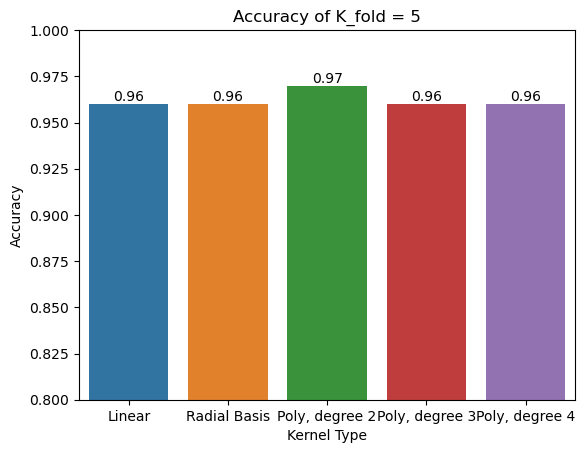

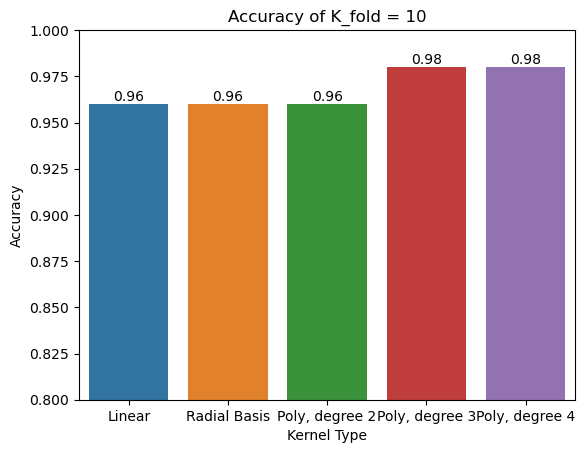

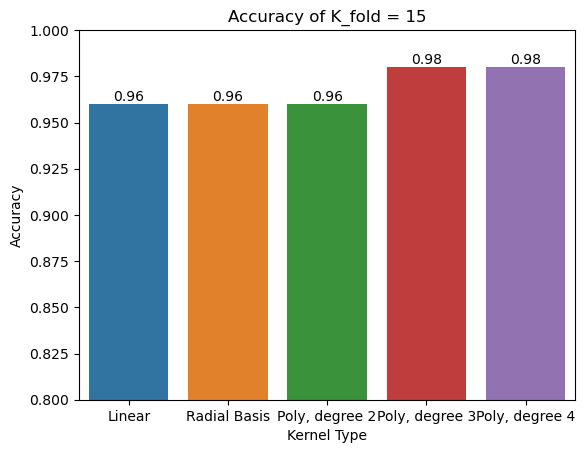

In [10]:
# A bar plot in seaborn for Accuracy of K_fold = 5 with a range of 0.8 to 1.0
data = {'Kernel Type': ['Linear', 'Radial Basis', 'Poly, degree 2', 'Poly, degree 3', 'Poly, degree 4'],
        'Accuracy': [
            0.96,
            0.96,
            0.97,
            0.96,
            0.96
        ]
        }
df = pd.DataFrame(data, columns=['Kernel Type', 'Accuracy'])
blob = sns.barplot(x='Kernel Type', y='Accuracy', data=df)
blob.set_ylim(0.8, 1.0)
blob.bar_label(blob.containers[0])
plt.title('Accuracy of K_fold = 5')
plt.show()

# A bar plot in seaborn for Accuracy of K_fold = 10
data = {'Kernel Type': ['Linear', 'Radial Basis', 'Poly, degree 2', 'Poly, degree 3', 'Poly, degree 4'],
        'Accuracy': [
            0.96,
            0.96,
            0.96,
            0.98,
            0.98
        ]
        }
df = pd.DataFrame(data, columns=['Kernel Type', 'Accuracy'])
blob = sns.barplot(x='Kernel Type', y='Accuracy', data=df)
blob.set_ylim(0.8, 1.0)
blob.bar_label(blob.containers[0])
plt.title('Accuracy of K_fold = 10')
plt.show()

# A bar plot in seaborn for Accuracy of K_fold = 15
data = {'Kernel Type': ['Linear', 'Radial Basis', 'Poly, degree 2', 'Poly, degree 3', 'Poly, degree 4'],
        'Accuracy': [
            0.96,
            0.96,
            0.96,
            0.98,
            0.98
        ]
        }
df = pd.DataFrame(data, columns=['Kernel Type', 'Accuracy'])
blob = sns.barplot(x='Kernel Type', y='Accuracy', data=df)
blob.set_ylim(0.8, 1.0)
blob.bar_label(blob.containers[0])
plt.title('Accuracy of K_fold = 15')
plt.show()

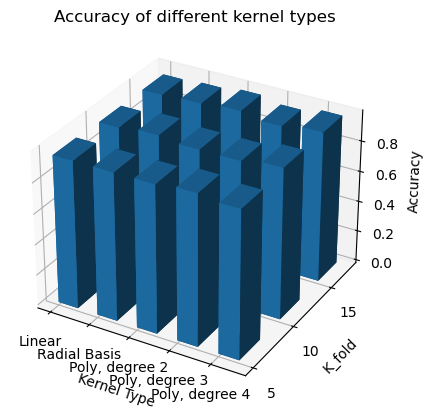

In [11]:
# A 3d surface plot for the accuracy of the different kernel types
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = ['Linear', 'Radial Basis', 'Poly, degree 2', 'Poly, degree 3', 'Poly, degree 4']
y = [5, 10, 15]
z = [
    [0.96, 0.95, 0.95, 0.96, 0.97],
    [0.96, 0.96, 0.95, 0.98, 0.98],
    [0.95, 0.95, 0.96, 0.98, 0.98]
]
xpos = np.arange(len(x))
ypos = np.arange(len(y))
xpos, ypos = np.meshgrid(xpos, ypos, indexing='ij')
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = 0.5
dz = np.array(z).ravel()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.set_yticks(np.arange(len(y)))
ax.set_yticklabels(y)
ax.set_xlabel('Kernel Type')
ax.set_ylabel('K_fold')
ax.set_zlabel('Accuracy')
plt.title('Accuracy of different kernel types')
plt.show()

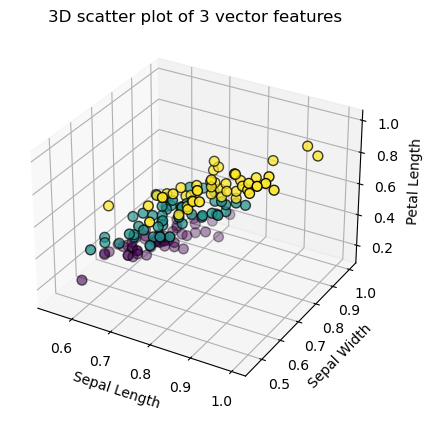

In [19]:
#  a 3d scatter plot for 3 vector features of the iris dataset
#  a meshgrid for the scatter plot
X = irisDF.iloc[:, :3]
Y = irisDF.iloc[:, -1]
h = .02
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
z_min, z_max = X.iloc[:, 2].min() - 1, X.iloc[:, 2].max() + 1
xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h),
                         np.arange(z_min, z_max, h))

# create a 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c=Y, cmap='viridis', s=50, edgecolors='k')
ax.set_xlabel('Sepal Length')
ax.set_ylabel('Sepal Width')
ax.set_zlabel('Petal Length')
ax.set_title('3D scatter plot of 3 vector features')
plt.show()